In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
from sklearn.decomposition import PCA
from evaluation import *

In [2]:
cwd = os.getcwd()

### Muraro example ###

In [3]:
# load labels and embeddings
X_train = np.load(f"{cwd}/data/muraro_log_pca.npy")
y_train = np.load(f"{cwd}/data/muraro_labels.npy")
pcaM = np.load(f"{cwd}/embeddings/Muraro/Muraro_pca.npy")
umapM = np.load(f"{cwd}/embeddings/Muraro/Muraro_umap.npy")

# create PCA reducer
reducer = PCA(n_components=2, random_state=42)

In [5]:
alpha_list = np.linspace(0,1,101) # 0 to 1 inclusive, step = 0.01
muraro_accs = [] # list of maps (created in loop)

# get and plot embeddings
for alpha in alpha_list:
    # scale UMAP, PCA embeddings by alpha, (1-alpha) respectively
    umapM_sc = umapM * (alpha) # sc for scaled
    pcaM_sc = pcaM * (1-alpha)
    # concatenate
    concat_emb = np.concatenate((pcaM_sc,umapM_sc), axis=1)
    # reduce to 2 dimensions
    embedding = reducer.fit_transform(concat_emb)
    embedding = embedding / LA.norm(embedding) # normalize scale to 1

    # dictionary to store results of this particular alpha val
    acc = dict()
    # store alpha
    acc['alpha'] = alpha

    # compute RT
    rt_acc = np.zeros(5,)
    for i in range(5):
        rt_acc[i] = random_triplet_eval(X_train, embedding, y_train) #X_train, embedding, labels
    acc['rt'] = np.mean(rt_acc)

    # compute CT
    #ct_acc = centroid_triplet_eval(X_train, embedding, y_train) #X_train, embedding, labels
    #acc['ct'] = np.mean(ct_acc)

    # compute kNN
    knn_acc = knn_eval(embedding, y_train, n_neighbors = 5)
    acc['knn'] = knn_acc

    muraro_accs.append(acc)
    
muraro_df = pd.DataFrame(muraro_accs)

muraro_df

KeyboardInterrupt: 

In [9]:
muraro_df.to_csv(f"{cwd}/muraro_df.csv", index=False)

In [5]:
muraro_df = pd.read_csv(f"{cwd}/muraro_df_with_ogf.csv")
alpha_list = np.linspace(0,1,101)

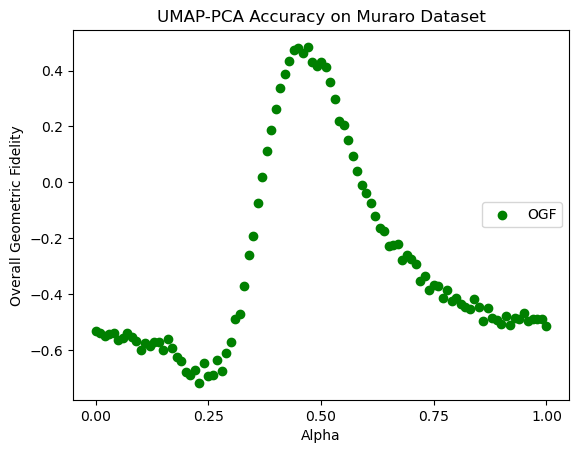

In [12]:
# create plot
#metrics = ['rt', 'knn', 'ogf'] # Corinne 9-19 -- remove CT metric, graph OGF
#color_map = {'rt': 'blue','knn':'red', 'ogf':'green'}
#label_map = {'rt': 'RT','knn': 'kNN', 'ogf':'OGF'}

metrics = ['ogf']
color_map = {'ogf':'green'}
label_map = {'ogf':'OGF'}


plt.figure()
for metric in metrics:
    plt.scatter(alpha_list, muraro_df[metric], color=color_map[metric],label= label_map[metric])
plt.xticks(np.linspace(0,1,5))
plt.title("UMAP-PCA Accuracy on Muraro Dataset")
plt.xlabel('Alpha')  
plt.ylabel('Overall Geometric Fidelity')
plt.legend(loc='right')
plt.show()

In [9]:
# what if I wanted to add OGF to Muraro plot?
# Corinne 9-19

mu_sig_df = pd.read_csv(f"{cwd}/mu_sig_df.csv")

rt_mu = mu_sig_df[mu_sig_df['metric']=='rt']['mean'].values[0]
rt_sig = mu_sig_df[mu_sig_df['metric']=='rt']['std'].values[0]
knn_mu = mu_sig_df[mu_sig_df['metric']=='knn']['mean'].values[0]
knn_sig = mu_sig_df[mu_sig_df['metric']=='knn']['std'].values[0]



In [14]:
muraro_copy = muraro_df
muraro_copy = muraro_copy.sort_values(by='alpha') # sort by alpha
muraro_copy['ogf'] = None

# Loop over the sorted index
for i, idx in enumerate(muraro_copy.index):
    rt = muraro_copy.at[idx, 'rt']
    knn = muraro_copy.at[idx, 'knn']

    zrt = (rt - rt_mu)/rt_sig
    zknn = (knn - knn_mu)/knn_sig

    muraro_copy.at[idx, 'ogf'] = 0.5*zrt + 0.5*zknn # save ogf

In [15]:
muraro_copy.to_csv(f"{cwd}/muraro_df_with_ogf.csv", index=False)

### Big bar graph ###

In [8]:
metrics_df = pd.read_csv(f"{cwd}/7-29_acc_df.csv")

# sort by algorithm and dataset
alg_order = ['pca','$\\alpha = $0.25','$\\alpha = $0.5','$\\alpha = $0.75','umap','pacmap','tsne']

metrics_df['algorithm'] = pd.Categorical(metrics_df['algorithm'], categories=alg_order, ordered=True)
#ogf_df['algorithm'] = pd.Categorical(ogf_df['algorithm'], categories=alg_order, ordered=True)

metrics_df = metrics_df.sort_values(by=['dataset','algorithm'])
ogf_df = ogf_df.sort_values(by=['dataset','algorithm'])

# titles and colors for plot
color_map = {'pca': '#C20E4B','$\\alpha = $0.25': '#A31F9F','$\\alpha = $0.5': '#651FA3' ,'$\\alpha = $0.75': '#231FA3','umap': '#1F5DA3', 'pacmap': '#CE6A00', 'tsne': '#8ACE00' }
colors = [color_map[alg] for alg in metrics_df['algorithm']]
alg_titles = {'pca': 'PCA','$\\alpha = $0.25': 'UMAP-PCA, \u03B1 = 0.25','$\\alpha = $0.5': 'UMAP-PCA, \u03B1 = 0.5' ,'$\\alpha = $0.75': 'UMAP-PCA, \u03B1 = 0.75','umap': 'UMAP', 'pacmap': 'PaCMAP', 'tsne': 't-SNE' }

In [75]:
metrics_df = pd.read_csv(f"{cwd}/all_knn_rt_10-1.csv")

# sort by algorithm and dataset
alg_order = ['pca','$\\alpha = $0.25','$\\alpha = $0.5','$\\alpha = $0.75','umap','$\\alpha = \\alpha^*$','pacmap','tsne']

metrics_df['algorithm'] = pd.Categorical(metrics_df['algorithm'], categories=alg_order, ordered=True)
#ogf_df['algorithm'] = pd.Categorical(ogf_df['algorithm'], categories=alg_order, ordered=True)

metrics_df = metrics_df.sort_values(by=['dataset','algorithm'])
#ogf_df = ogf_df.sort_values(by=['dataset','algorithm'])

# titles and colors for plot
#color_map = {'pca': '#FF4DD5','$\\alpha = $0.25': '#E01AB5','$\\alpha = $0.5': '#9F0BC9' ,'$\\alpha = $0.75': '#5B00B6','umap': '#0000A5', 'pacmap': '#CE6A00', 'tsne': '#8ACE00', '$\\alpha = \\alpha^*$': '#0FEBFF'}
color_map = {'pca': '#8ACE00','$\\alpha = $0.25': '#00AAB9','$\\alpha = $0.5': '#1D59E4' ,'$\\alpha = $0.75': '#2113B9','umap': '#6403A0', 'pacmap': '#D03875', 'tsne': '#FFC800', '$\\alpha = \\alpha^*$': '#00DDFF'}
colors = [color_map[alg] for alg in metrics_df['algorithm']]
alg_titles = {'pca': 'PCA','$\\alpha = $0.25': 'Hybrid(0.25)','$\\alpha = $0.5': 'Hybrid(0.5)' ,'$\\alpha = $0.75': 'Hybrid(0.75)','umap': 'UMAP', 'pacmap': 'PaCMAP', 'tsne': 't-SNE', '$\\alpha = \\alpha^*$':'Hybrid($\\alpha^*$)'}


#### legend ####

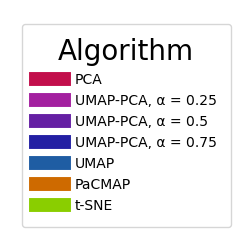

In [8]:
lw = 10

legend_elems = []
for alg in alg_order:
    legend_elems.append(Line2D([0], [0], color=color_map[alg], lw=lw))
                

#  Create the figure
plt.figure(figsize=(3,3))
plt.legend(legend_elems, [alg_titles[alg] for alg in alg_order], loc="center", title="Algorithm", title_fontsize=20, borderpad=1., labelspacing=0.5)
plt.axis('off')
#plt.tight_layout()
plt.savefig('legend', transparent=True)
plt.show()

#### RT, CT, kNN ####

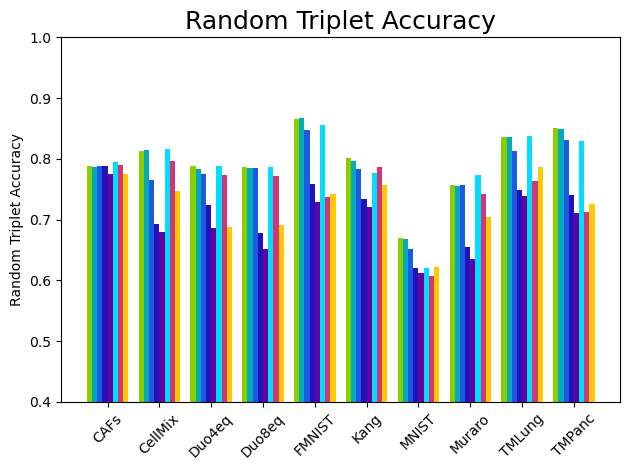

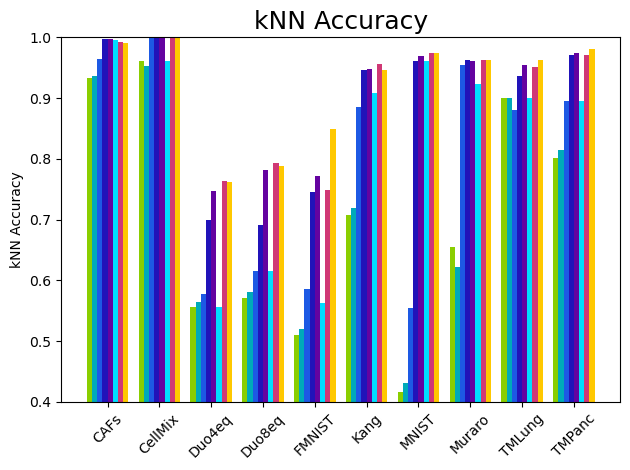

In [76]:
datasets = metrics_df['dataset'].unique()
algs = metrics_df['algorithm'].unique()

metric_titles = {'rt': 'Random Triplet Accuracy', 'knn': 'kNN Accuracy'}

bar_width = 0.8 / len(algs)


metrics = ['rt', 'knn']

for metric in metrics:
    # Create a new figure
    fig, ax = plt.subplots()

    met_df = metrics_df[['dataset', 'algorithm', metric]]
    # loop through algs
    for i, alg in enumerate(algs):
        #alg_data = metrics_df[metrics_df['algorithm'] == alg]
        alg_data = met_df[met_df['algorithm'] == alg]

        # Position the bars on the x-axis
        x_positions = np.arange(len(datasets)) + i * bar_width - (len(algs) - 1) * bar_width / 2

        # plot bars
        ax.bar(x_positions, alg_data[metric].values, width=bar_width, color=color_map[alg], label=alg_titles[alg])

    plt.title(metric_titles[metric],fontsize=18)
    plt.ylabel(metric_titles[metric])

    # Set x-ticks to correspond to dataset names
    ax.set_xticks(np.arange(len(datasets)))
    ax.set_xticklabels(datasets, rotation=45)

    plt.ylim(0.4,1)
    plt.tight_layout()
    plt.show()

#### OGF ####

In [71]:
ogf_df = pd.read_csv(f"{cwd}/all_ogf_10-1.csv")
# sort by algorithm and dataset
alg_order = ['pca','$\\alpha = $0.25','$\\alpha = $0.5','$\\alpha = $0.75','umap','$\\alpha = \\alpha^*$','pacmap','tsne']

metrics_df['algorithm'] = pd.Categorical(metrics_df['algorithm'], categories=alg_order, ordered=True)
ogf_df['algorithm'] = pd.Categorical(ogf_df['algorithm'], categories=alg_order, ordered=True)

metrics_df = metrics_df.sort_values(by=['dataset','algorithm'])
ogf_df = ogf_df.sort_values(by=['dataset','algorithm'])

# titles and colors for plot
#color_map = {'pca': '#FF4DD5','$\\alpha = $0.25': '#E01AB5','$\\alpha = $0.5': '#9F0BC9' ,'$\\alpha = $0.75': '#5B00B6','umap': '#0000A5', 'pacmap': '#CE6A00', 'tsne': '#8ACE00', '$\\alpha = \\alpha^*$': '#0FEBFF'}
color_map = {'pca': '#8ACE00','$\\alpha = $0.25': '#00AAB9','$\\alpha = $0.5': '#1D59E4' ,'$\\alpha = $0.75': '#2113B9','umap': '#6403A0', 'pacmap': '#D03875', 'tsne': '#FFC800', '$\\alpha = \\alpha^*$': '#00DDFF'}
colors = [color_map[alg] for alg in metrics_df['algorithm']]
alg_titles = {'pca': 'PCA','$\\alpha = $0.25': 'Hybrid(0.25)','$\\alpha = $0.5': 'Hybrid(0.5)' ,'$\\alpha = $0.75': 'Hybrid(0.75)','umap': 'UMAP', 'pacmap': 'PaCMAP', 'tsne': 't-SNE', '$\\alpha = \\alpha^*$':'Hybrid($\\alpha^*$)'}


(-2.1, 1.0)

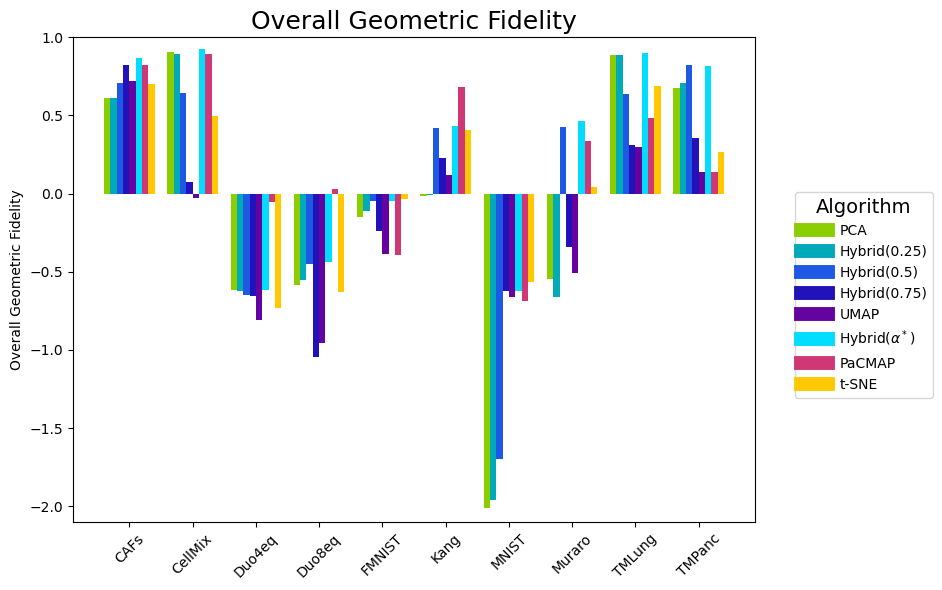

In [72]:
datasets = ogf_df['dataset'].unique()
algs = ogf_df['algorithm'].unique()


bar_width = 0.8 / len(algs)

# Create a new figure
fig, ax = plt.subplots(figsize=(8,6))
                

#  Create the figure
#plt.figure(figsize=(3,3))
#plt.legend(legend_elems, [alg_titles[alg] for alg in alg_order], loc="center", title="Algorithm", title_fontsize=20, borderpad=1., labelspacing=0.5)
#plt.axis('off')
#plt.tight_layout()
#plt.savefig('legend', transparent=True)

# loop through algs
for i, alg in enumerate(algs):
    alg_data = ogf_df[ogf_df['algorithm'] == alg]

    # Position the bars on the x-axis
    x_positions = np.arange(len(datasets)) + i * bar_width - (len(algs) - 1) * bar_width / 2

    # plot bars
    ax.bar(x_positions, alg_data['ogf'].values, width=bar_width, color=color_map[alg])

ax.set_title('Overall Geometric Fidelity',fontsize=18)
ax.set_ylabel('Overall Geometric Fidelity')

# Set x-ticks to correspond to dataset names
ax.set_xticks(np.arange(len(datasets)))
ax.set_xticklabels(datasets, rotation=45)

# 10-1
# Create custom legend elements
lw = 10
legend_elems = [Line2D([0], [0], color=color_map[alg], lw=lw) for alg in alg_order]
legend_labels = [alg_titles[alg] for alg in alg_order]

# Add legend to the right of the figure (not the axes!)
fig.legend(
    legend_elems,
    legend_labels,
    title="Algorithm",
    title_fontsize=14,
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),  # (x, y) relative to figure
    borderaxespad=0.
)

# Adjust layout so legend fits in the figure
plt.tight_layout()
plt.subplots_adjust(right=0.95)  # Reserve space on the right
#10-1

plt.ylim(-2.1,1)
#plt.tight_layout()

#plt.show()